In [14]:
%load_ext autoreload
%autoreload 2

import re
import os
import sys
sys.path.insert(0, os.path.realpath('/content/jupyter/mta-accessibility/notebooks/routing'))
from gcs_utils import gcs_util

import os.path
from os import listdir
from os.path import isfile, join
from google.transit import gtfs_realtime_pb2 as gtfs_rt
from protobuf_to_dict import protobuf_to_dict
from datetime import datetime
import numpy as np
import pandas as pd

pd.set_option('max_colwidth', 200)
gcs = gcs_util()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Notes
- Slider bar to show distribution over time
- Figure out negative delays, handle sequence checking
- Handle train directions
- Look through why some days are not loading
- How to quickly get distribution

In [16]:
gcs.list_dirs()

date_pattern = re.compile("hourly_vehicle_update/([0-9]*)_([0-9]*)\.pkl")
date_count = {}

for blob in gcs.list_blobs('hourly_vehicle_update'):        
    date = date_pattern.match(blob.name)[1]
    date_count[date] = date_count.get(date, 0) + 1
    
date_count

{'20190601': 18,
 '20190602': 12,
 '20190603': 6,
 '20190604': 3,
 '20190605': 5,
 '20190606': 3,
 '20190607': 4,
 '20190608': 13,
 '20190609': 14,
 '20190610': 3,
 '20190612': 3,
 '20190613': 1,
 '20190614': 2,
 '20190615': 8,
 '20190616': 15,
 '20190617': 3,
 '20190618': 2,
 '20190619': 2,
 '20190620': 1,
 '20190621': 12,
 '20190622': 15,
 '20190623': 11,
 '20190624': 14,
 '20190625': 3,
 '20190626': 14,
 '20190627': 14,
 '20190628': 17,
 '20190629': 20,
 '20190630': 16}

In [17]:
#gcs.delete_blob_dir("hourly_vehicle_update/")

In [18]:
%time
date_pattern = re.compile("hourly_vehicle_update/([0-9]*)_([0-9]*)\.pkl")

keep_dates = ['20190601']
loaded_files = []
df = pd.DataFrame()
for blob in gcs.list_blobs('hourly_vehicle_update'):    
    name = blob.name
    date = date_pattern.match(name)[1]
    hour = date_pattern.match(name)[2]
    if date in keep_dates:
        loaded_files.append(blob.name)
        print(blob.name)
        df_temp = gcs.read_dataframe(name)
        df = df.append(df_temp).drop_duplicates()        

print(len(df.index))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.4 µs
hourly_vehicle_update/20190601_04.pkl
hourly_vehicle_update/20190601_05.pkl
hourly_vehicle_update/20190601_06.pkl
hourly_vehicle_update/20190601_07.pkl
hourly_vehicle_update/20190601_08.pkl
hourly_vehicle_update/20190601_09.pkl
hourly_vehicle_update/20190601_10.pkl
hourly_vehicle_update/20190601_11.pkl
hourly_vehicle_update/20190601_12.pkl
hourly_vehicle_update/20190601_13.pkl
hourly_vehicle_update/20190601_14.pkl
hourly_vehicle_update/20190601_16.pkl
hourly_vehicle_update/20190601_17.pkl
hourly_vehicle_update/20190601_18.pkl
hourly_vehicle_update/20190601_19.pkl
hourly_vehicle_update/20190601_20.pkl
hourly_vehicle_update/20190601_21.pkl
hourly_vehicle_update/20190601_22.pkl
407076


%time
all_blobs = gcs.list_blobs('hourly_vehicle_update')
[print(blob) for blob in all_blobs]

df = pd.DataFrame()
for blob in all_blobs:
    name = blob.name
    d = gcs.read_dataframe(name)        
    df = df.append(d)

print(len(df.index))

## GTFS with Vehicle Updates

In [19]:
# Id column seems useless
df = df.drop(columns=['id']).drop_duplicates()
df.head()

,current_status,current_stop_sequence,stop_id,timestamp,route_id,start_date,start_time,trip_id,stop_name
0,NaN,38.0,N07,NaT,N,20190601,03:30:03,021005_N..S,Bay Pkwy
1,NaN,4.0,N07,2019-06-01 08:26:24,N,20190601,04:16:30,025650_N..N,Bay Pkwy
2,NaN,38.0,N07,2019-06-01 08:33:49,N,20190601,03:10:25,019041_N..S,Bay Pkwy
3,NaN,38.0,N07,2019-06-01 08:33:39,N,20190601,03:10:25,019041_N..S,Bay Pkwy
4,NaN,38.0,N07,2019-06-01 08:33:04,N,20190601,03:10:25,019041_N..S,Bay Pkwy


In [25]:
from typing import List

stop_df = gcs.read_dataframe('google_transit/stops.pkl')[['stop_id', 'stop_name']]
slim_stop_df = stop_df.copy()
slim_stop_df['stop_name'] = slim_stop_df.stop_name.str.lower()

def get_stop_ids(stop_name: str) -> List[str]:
    return list(slim_stop_df[slim_stop_df.stop_name.str.contains(stop_name.lower())].stop_id)


def create_histogram(stop1: str, stop2: str, df: pd.DataFrame):
    # Drop if timestamp or current_stop_sequence are null
    df = df[(df.current_stop_sequence.notnull()) & (df.timestamp.notnull())]
    # Take the first row for each sequence_number
    df = df.groupby(['start_date', 'start_time', 'route_id', 'current_stop_sequence']).first().reset_index()
    
    # Keep only rows with the stops we're interested in
    stop_ids = get_stop_ids(stop1) + get_stop_ids(stop2)
    df = df[df.stop_id.isin(stop_ids)]
        
    def compute_stop_diff(df):
        # Maybe check the sequence order of stops? Handle North/South trains?        
        if (len(df.index) != 2):
            return pd.DataFrame()
        df['diff'] = df.timestamp.diff()
        return df.filter(['timestamp', 'diff']).dropna()
    
    stats = df.groupby(['start_date', 'start_time', 'route_id']).apply(compute_stop_diff).reset_index()
    stats['diff'].astype('timedelta64[m]').plot.hist()
    return stats

In [26]:
df.groupby('route_id')['stop_id'].count().sort_values()

route_id
7X      145
FS      609
H      4451
E     19361
J     22437
7     23901
G     25068
M     26167
R     28352
C     29411
D     29873
Q     30066
N     30331
F     35017
A     43952
Name: stop_id, dtype: int64

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.7 µs


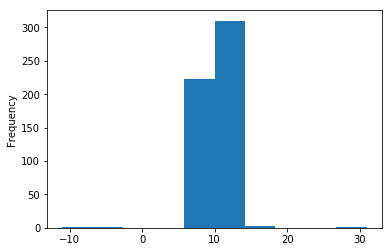

In [27]:
%time
stats = create_histogram('canal', 'port authority', df)


In [346]:
stats[stats['diff'].astype(int) < 0]

,start_date,start_time,route_id,level_3,timestamp,diff
443,20190601,19:07:00,N,50357,2019-06-01 23:43:24,-1 days +23:49:10
449,20190601,19:18:30,A,51121,2019-06-01 23:54:00,-1 days +23:57:26


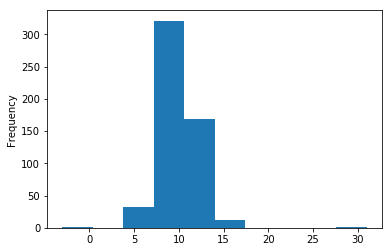

In [347]:
stats = create_histogram('canal', 'port authority', df[df.route_id.isin(['A','C','E'])])

9.416666666666666

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.4 µs


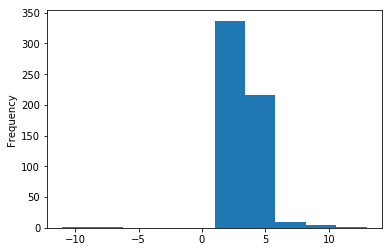

In [338]:
%time
create_histogram('fulton', 'canal', df)

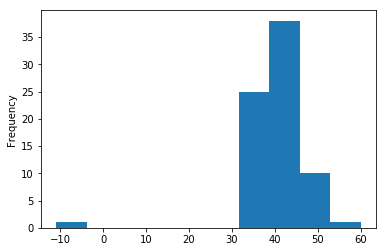

In [339]:
create_histogram('canal', 'inwood', df)

In [124]:
df = vdf.drop(columns='id').drop_duplicates()
# Drop if timestamp or current_stop_sequence are null
df = df[(df.current_stop_sequence.notnull()) & (df.timestamp.notnull())]

#df['count']= df.groupby(['start_date', 'start_time', 'route_id'])['stop_id'].transform('count')
# Only keep groups with greater than 20 stops
#df = df[df['count'] >= 20]

df = df.groupby(['start_date', 'start_time', 'route_id', 'current_stop_sequence']).first().reset_index()
#df.sort_values(['start_time','route_id','timestamp','current_stop_sequence'])

In [125]:
%time
# From Canal to 14 st
def compute_diff(df: pd.DataFrame) -> pd.DataFrame:        
    if (len(df.index) == 2):        
        df['diff'] = df.timestamp.diff()        
        return df.filter(['timestamp', 'diff']).dropna()
    else:        
        return pd.DataFrame()

dest_src_df = df[(df.stop_name.str.contains('Canal')) | (df.stop_name.str.contains('14 St'))]
stats = dest_src_df.groupby(['start_date', 'start_time', 'route_id']).apply(compute_diff).reset_index()



CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.78 µs


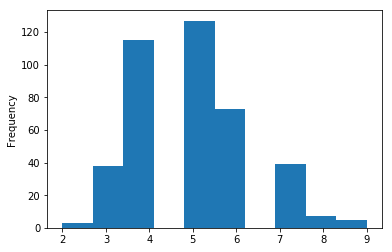

In [126]:
stats['diff'].astype('timedelta64[m]').plot.hist()

%%time
gcs = gcs_util()
df = gcs.read_dataframe('hourly_gtfs/20190601_07.pkl')

df.columns = df.columns.str.replace('trip_update.trip.', '')
df.columns = df.columns.str.replace('.', '_')

df.arrival_time = pd.to_datetime(df.arrival_time, unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York')
df.departure_time = pd.to_datetime(df.departure_time, unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

# Join with static GTFS data.
stop_df = pd.read_csv('google_transit/stops.txt')
df = df.merge(stop_df[['stop_id', 'stop_name']], on='stop_id')
gcs.upload_dataframe(df, 'merged_hourly_gtfs/20190601_07.pkl')

df.head()

### Read rolled-up hourly files

In [40]:

df = gcs.read_dataframe('merged_hourly_gtfs/20190601_07.pkl')

In [41]:
dfa = df[df.route_id == 'A'].drop_duplicates()
dfa = dfa[(dfa.arrival_time > '2019-06-01 7:30:00-04:00') & (dfa.arrival_time < '2019-06-01 7:35:00-04:00')]
dfa = dfa.drop(columns='id')
dfa.head()

,arrival_time,departure_time,schedule_relationship,stop_id,route_id,start_date,start_time,trip_id,stop_name
191418,2019-06-01 07:30:09-04:00,2019-06-01 07:30:09-04:00,NaN,A40S,A,20190601,05:55:31,035551_A..S,High St
191499,2019-06-01 07:30:25-04:00,2019-06-01 07:30:25-04:00,NaN,A40S,A,20190601,05:55:31,035551_A..S,High St
191502,2019-06-01 07:30:25-04:00,2019-06-01 07:30:25-04:00,NaN,A40S,A,20190601,06:49:35,040958_A..S,High St
191680,2019-06-01 07:32:25-04:00,2019-06-01 07:32:25-04:00,NaN,A40S,A,20190601,05:55:31,035551_A..S,High St
192048,2019-06-01 07:30:09-04:00,2019-06-01 07:30:09-04:00,NaN,A40S,A,20190601,05:55:31,035551_A..S,High St


In [21]:
# Trip ids all over the place.
# Much duplicate data
dfa.groupby('trip_id')['stop_name'].nunique()

trip_id
034956_A..N     2
035551_A..S    13
036301_A..S     6
037150_A..N     2
037950_A..S     2
038200_A..N     4
038958_A..S     3
039163_A..N     3
039950_A..S     2
040250_A..N     1
040958_A..S     3
041150_A..N     2
041950_A..S     4
042250_A..N     4
042948_A..S     3
042950_A..S     1
043150_A..N     3
043200_A..N     7
043950_A..S     1
043951_A..S     2
044250_A..N     2
044750_A..N     3
044950_A..S     4
045048_A..N     4
Name: stop_name, dtype: int64

## Read Tripifier Files

In [36]:
df = gcs.read_dataframe('tripify/tripified.pkl')
df.head()

,trip_id,route_id,action,minimum_time,maximum_time,stop_id,latest_information_time,unique_trip_id,stop_name
0,031350_E..S,E,EN_ROUTE_TO,2019-06-01 22:02:05,NaT,G05S,2019-06-01 22:02:05,083300_E..S_1559408369,Jamaica Center - Parsons/Archer
1,029400_E..S,E,STOPPED_AT,2019-06-01 11:31:15,2019-06-01 13:02:04,G05S,2019-06-01 20:05:24,079700_E..S_1559405859,Jamaica Center - Parsons/Archer
2,029350_E..S,E,STOPPED_OR_SKIPPED,2019-06-02 01:58:51,2019-06-01 08:55:17,G05S,2019-06-01 15:00:53,136250_E..S_1559440731,Jamaica Center - Parsons/Archer
3,029400_E..S,E,STOPPED_OR_SKIPPED,2019-06-01 11:37:47,2019-06-01 11:37:47,G05S,2019-06-01 11:37:47,061730_E..S_1559399874,Jamaica Center - Parsons/Archer
4,050900_E..S,E,STOPPED_OR_SKIPPED,2019-06-01 12:14:00,2019-06-01 12:14:00,G05S,2019-06-01 12:14:00,064100_E..S_1559399010,Jamaica Center - Parsons/Archer


In [38]:
df[df.route_id == 'E'].sort_values('unique_trip_id').head()

,trip_id,route_id,action,minimum_time,maximum_time,stop_id,latest_information_time,unique_trip_id,stop_name
10570,020833_E..N,E,STOPPED_OR_SKIPPED,2019-06-01 08:23:16,2019-06-01 08:23:16,G07N,2019-06-01 08:23:16,020833_E..N_1559377396,Jamaica - Van Wyck
20381,020833_E..N,E,STOPPED_OR_SKIPPED,2019-06-01 08:23:16,2019-06-01 08:23:16,G05N,2019-06-01 08:23:16,020833_E..N_1559377396,Jamaica Center - Parsons/Archer
10895,020833_E..N,E,STOPPED_OR_SKIPPED,2019-06-01 08:23:16,2019-06-01 08:23:16,G06N,2019-06-01 08:23:16,020833_E..N_1559377396,Sutphin Blvd - Archer Av - JFK Airport
19628,020833_E..N,E,STOPPED_OR_SKIPPED,2019-06-01 08:23:16,2019-06-01 08:23:16,F06N,2019-06-01 08:23:16,020833_E..N_1559377396,Kew Gardens - Union Tpke
8630,021300_E..S,E,STOPPED_OR_SKIPPED,2019-06-01 08:23:16,2019-06-01 08:23:16,E01S,2019-06-01 08:23:16,021300_E..S_1559377396,World Trade Center


In [39]:
# Most of these entries have the same unique_trip_id and time
df.groupby(['unique_trip_id', 'minimum_time']).count().head()

,,trip_id,route_id,action,maximum_time,stop_id,latest_information_time,stop_name
unique_trip_id,minimum_time,,,,,,,
000000_FS..S_1559444666,2019-06-02 03:04:26,4,4,4,0,4,4,4
000000_FS..S_1559445810,2019-06-02 03:23:30,4,4,4,0,4,4,4
000000_FS..S_1559446191,2019-06-02 03:29:51,4,4,4,0,4,4,4
000000_FS..S_1559446461,2019-06-02 03:34:21,4,4,4,0,4,4,4
000200_A..N_1559445810,2019-06-01 19:29:28,56,56,56,56,56,56,56
000300_H..S_1559444666,2019-06-02 03:04:26,6,6,6,0,6,6,6
000300_H..S_1559446191,2019-06-02 03:29:51,6,6,6,0,6,6,6
000300_H..S_1559446461,2019-06-02 03:34:21,6,6,6,0,6,6,6
000950_FS..N_1559445810,2019-06-02 03:23:30,4,4,4,0,4,4,4


In [16]:
#df[df.stop_id =='L03N'].sort_values(['arrival_time']).drop_duplicates()
#df.groupby('trip_id').count()
df = df.drop_duplicates()

In [30]:
df[df.stop_name.str.contains('Canal')].stop_id.unique()

array(['M20S', 'M20N', 'A34N', 'A34S', 'Q01N', 'Q01S', 'R23S', 'R23N'],
      dtype=object)

In [28]:
cdf = df[df.stop_name.str.contains('Canal')]
#cdf.sort_values('arrival_time')
np.mean(cdf.arrival_time.sort_values().drop_duplicates().diff())

Timedelta('0 days 00:00:05.886287')

In [33]:
%%time

avg_wait = {}
for hour in range(3,24):
    
    df = pd.read_pickle(f"hourly/20190601_{hour:02}.pkl")
    df.drop_duplicates()
    df.columns = df.columns.str.replace('trip_update.trip.', '')
    df.columns = df.columns.str.replace('.', '_')

    #df.arrival_time = pd.to_datetime(df.arrival_time, unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York')
    #df.departure_time = pd.to_datetime(df.departure_time, unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York')

    # Join with static GTFS data.
    stop_df = pd.read_csv('google_transit/stops.txt')
    df = df.merge(stop_df[['stop_id', 'stop_name']], on='stop_id')

    cdf = df[df.stop_name.str.contains('Canal')]
    avg_wait[hour] = np.mean(cdf.arrival_time.sort_values().drop_duplicates().diff())

avg_wait

CPU times: user 1min 56s, sys: 8.2 s, total: 2min 4s
Wall time: 2min 13s


{3: nan,
 4: 9.009109311740891,
 5: 7.676911544227886,
 6: 6.249851983422143,
 7: 5.88628762541806,
 8: 5.688542227003765,
 9: 5.558715113217483,
 10: 5.587209302325581,
 11: 5.727618014107433,
 12: 5.683333333333334,
 13: 5.844961240310077,
 14: 5.699784017278618,
 15: 5.635878270154832,
 16: 5.58862506902264,
 17: 5.651880965749579,
 18: 5.766285714285714,
 19: 5.920256111757858,
 20: 6.222354340071344,
 21: 5.979881656804734,
 22: 6.298397040690506,
 23: 7.297826086956522}

In [39]:
x = list(avg_wait.keys())
y = list(avg_wait.values())

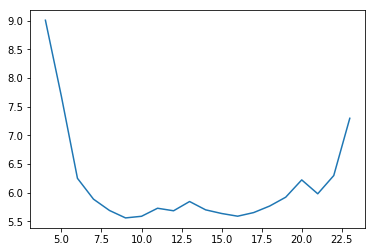

In [41]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(x,y)

In [485]:
# TODO Look at the original feed to see why there are duplicate rows?
# File name should be somewhere around 7:12 EST -> 12:12 GMT
df2 = df[df.trip_id == '043205_J..S']

In [489]:
df2.drop_duplicates().sort_values(['trip_id', 'id'])

,arrival_time,departure_time,schedule_relationship,stop_id,id,route_id,start_date,start_time,trip_id,stop_name
124359,2019-06-01 07:34:49-04:00,2019-06-01 07:34:49-04:00,NaN,M20S,000001J,J,20190601,07:12:03,043205_J..S,Canal St
124486,2019-06-01 07:34:59-04:00,2019-06-01 07:34:59-04:00,NaN,M20S,000001J,J,20190601,07:12:03,043205_J..S,Canal St
126141,2019-06-01 07:36:14-04:00,2019-06-01 07:36:14-04:00,NaN,M21S,000001J,J,20190601,07:12:03,043205_J..S,Chambers St
126223,2019-06-01 07:35:55-04:00,2019-06-01 07:35:55-04:00,NaN,M21S,000001J,J,20190601,07:12:03,043205_J..S,Chambers St
126352,2019-06-01 07:36:07-04:00,2019-06-01 07:36:07-04:00,NaN,M21S,000001J,J,20190601,07:12:03,043205_J..S,Chambers St
126993,2019-06-01 07:37:49-04:00,2019-06-01 07:37:49-04:00,NaN,M22S,000001J,J,20190601,07:12:03,043205_J..S,Fulton St
127011,2019-06-01 07:37:59-04:00,2019-06-01 07:37:59-04:00,NaN,M22S,000001J,J,20190601,07:12:03,043205_J..S,Fulton St
127742,2019-06-01 07:37:04-04:00,2019-06-01 07:37:04-04:00,NaN,M22S,000001J,J,20190601,07:12:03,043205_J..S,Fulton St
128030,2019-06-01 07:37:19-04:00,2019-06-01 07:37:19-04:00,NaN,M22S,000001J,J,20190601,07:12:03,043205_J..S,Fulton St
128114,2019-06-01 07:37:25-04:00,2019-06-01 07:37:25-04:00,NaN,M22S,000001J,J,20190601,07:12:03,043205_J..S,Fulton St


In [462]:
# Compute average and median time from port auth to canal

#df[df.stop_name == 'Canal St']

In [368]:
def parse_data(realtime_data):
    df = pd.DataFrame.from_dict(realtime_data)
    
    # Horizontally explode trip_update dict
    df = df['trip_update'].apply(pd.Series)
    # Horizontally explode trip_id dict
    df = pd.concat([df.trip.apply(pd.Series), df.stop_time_update], axis=1)
    # Get rid of null stop_time_updates
    df = df[~df.stop_time_update.isnull()]

    # Explode out each row of stop_time_update
    idx = df.index.repeat(df['stop_time_update'].str.len())
    df1 = pd.DataFrame({'stop_time_update': np.concatenate(df.stop_time_update.values)})
    df1.index = idx
    df = df1.join(df.drop('stop_time_update', axis=1), how='left')

    # Explode horizontally arrival,departure, and stop_id
    df1 = df.stop_time_update.apply(pd.Series)
    df = pd.concat([df.drop(['stop_time_update'], axis=1), df1], axis=1)

    # Convert arrival and departure times to datetime.
    df.arrival = df.arrival.apply(pd.Series)
    df.arrival = pd.to_datetime(df.arrival, unit='s')

    df.departure = df.departure.apply(pd.Series)
    df.departure = pd.to_datetime(df.departure, unit='s')
    return df

In [269]:
df = pd.DataFrame.from_dict(realtime_data)
# Dump all vehicle updates
df = df[df.vehicle.isnull()].drop(columns=['vehicle'])
# Horizontally explode trip_update dict
df = df['trip_update'].apply(pd.Series)
# Horizontally explode trip_id dict
df = pd.concat([df.trip.apply(pd.Series), df.stop_time_update], axis=1)
# Get rid of null stop_time_updates
df = df[~df.stop_time_update.isnull()]

# Explode out each row of stop_time_update
idx = df.index.repeat(df['stop_time_update'].str.len())
df1 = pd.DataFrame({'stop_time_update': np.concatenate(df.stop_time_update.values)})
df1.index = idx
df = df1.join(df.drop('stop_time_update', axis=1), how='left')

# Explode horizontally arrival,departure, and stop_id
df1 = df.stop_time_update.apply(pd.Series)
df = pd.concat([df.drop(['stop_time_update'], axis=1), df1], axis=1)

# Convert arrival and departure times to datetime.
df.arrival = df.arrival.apply(pd.Series)
df.arrival = pd.to_datetime(df.arrival, unit='s')

df.departure = df.departure.apply(pd.Series)
df.departure = pd.to_datetime(df.departure, unit='s')

df.head()

,trip_id,start_time,start_date,route_id,arrival,departure,stop_id
0,035551_A..S,05:55:31,20190601,A,2019-06-01 11:30:09,2019-06-01 11:30:09,A40S
0,035551_A..S,05:55:31,20190601,A,2019-06-01 11:32:39,2019-06-01 11:32:39,A41S
0,035551_A..S,05:55:31,20190601,A,2019-06-01 11:34:39,2019-06-01 11:34:39,A42S
0,035551_A..S,05:55:31,20190601,A,2019-06-01 11:39:39,2019-06-01 11:39:39,A46S
0,035551_A..S,05:55:31,20190601,A,2019-06-01 11:42:09,2019-06-01 11:42:09,A48S
